<a href="https://www.kaggle.com/code/evelynartoria/chess-pieces-classification-pytorch-tinyvgg?scriptVersionId=187342089" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Import needed libraries

In [2]:
import torch
import torchvision
from torch import nn
from torchvision import transforms
from torch.utils.data import DataLoader, TensorDataset

import PIL
import glob

from tqdm import tqdm

import matplotlib.pyplot as plt

# Device agnostic code

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_default_device(device)
print(f"default device set to {device}")

default device set to cpu


# Prepare the data

In [4]:
data = []
sample_image = "/kaggle/input/chess-pieces-detection-images-dataset/Queen-Resized/00000000_resized.jpg"
converter = transforms.ToTensor()
sample_image_tensor = converter(PIL.Image.open(sample_image))

In [5]:

#glob.glob("/kaggle/input/chess-pieces-detection-images-dataset/Queen-Resized/*")
pieces_folders_1 = glob.glob("/kaggle/input/chess-pieces-detection-images-dataset/*")
pieces_folders_2 = glob.glob("/kaggle/input/chess-pieces-dataset-85x85/data/*")

bishop_images = glob.glob("/kaggle/input/chess-pieces-dataset-85x85/data/bishop/*")
king_images = glob.glob("/kaggle/input/chess-pieces-dataset-85x85/data/king/*")
knight_images = glob.glob("/kaggle/input/chess-pieces-dataset-85x85/data/knight/*")
pawn_images = glob.glob("/kaggle/input/chess-pieces-dataset-85x85/data/pawn/*")
queen_images = glob.glob("/kaggle/input/chess-pieces-dataset-85x85/data/queen/*")
rook_images = glob.glob("/kaggle/input/chess-pieces-dataset-85x85/data/rook/*")

image_paths = {
    "bishop": bishop_images,
    "king": king_images,
    "knight": knight_images,
    "pawn": pawn_images,
    "queen": queen_images,
    "rook": rook_images
}

In [6]:
n_classes = len(image_paths)
classes = {
    "bishop": 0,
    "king": 1,
    "knight": 2,
    "pawn": 3,
    "queen": 4,
    "rook": 5
}

id_to_class = {v:c for c, v in classes.items()}
print(id_to_class)

{0: 'bishop', 1: 'king', 2: 'knight', 3: 'pawn', 4: 'queen', 5: 'rook'}


# From images to tensors

In [7]:
def image_to_tensor(image_path, converter):
    image = PIL.Image.open(image_path)
    image_tensor = converter(image)
    return image_tensor

def plot_image(tensor):
    plt.imshow(tensor.permute(1, 2, 0))

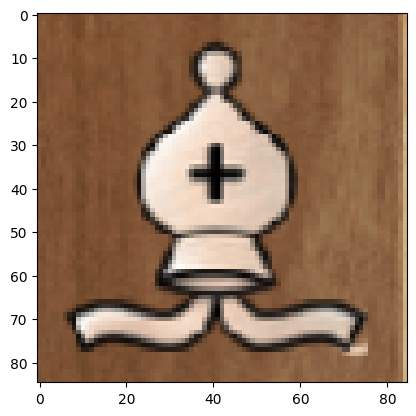

In [8]:
converter = torchvision.transforms.ToTensor()
image_tensor = image_to_tensor("/kaggle/input/chess-pieces-dataset-85x85/data/bishop/100.png", converter=converter)
plot_image(image_tensor)

# Construct the dataset and dataloader

In [9]:
images = []
labels = []
converter = torchvision.transforms.ToTensor()
for label, image_path_array in image_paths.items():
    for image_path in image_path_array:
        #print(image_path, label)
        image_tensor = image_to_tensor(image_path=image_path, converter=converter)
        images.append(image_tensor)
        labels.append(classes[label])
    #image_tensor = image_to_tensor(image_path=image_path, converter=converter)
    #print(image_tensor.shape)
    
images_tensor = torch.stack(images)
labels_tensor = torch.tensor(labels)
print(images_tensor.shape)
print(labels_tensor.shape)

torch.Size([517, 3, 85, 85])
torch.Size([517])


In [10]:
dataset = TensorDataset(images_tensor, labels_tensor)
dataloader = DataLoader(dataset=dataset, batch_size=32, shuffle=True, generator=torch.Generator(device=device))

king


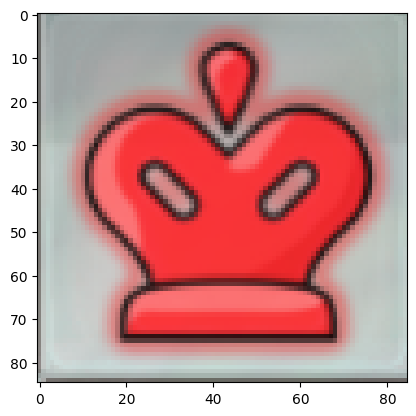

In [11]:
batch_sample_images, batch_sample_labels = next(iter(dataloader))
sample, sample_label = batch_sample_images[0], batch_sample_labels[0]
plot_image(sample)
print(id_to_class[sample_label.item()])

# TinyVGG model

In [12]:
class TinyVGG(nn.Module):
    def __init__(self, channels, hidden_units, n_classes):
        super().__init__()
        
        self.conv2d_kernel_size = 3

        self.conv2d_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=channels, out_channels=hidden_units, kernel_size=self.conv2d_kernel_size, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=self.conv2d_kernel_size, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2))
        )
        
        self.conv2d_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=self.conv2d_kernel_size, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=self.conv2d_kernel_size, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2))
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=4410, out_features=n_classes)
        )
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv2d_block_1(x)
        x = self.conv2d_block_2(x)
        #print(x.shape)
        x = self.classifier(x)
        
        return x

In [13]:
tinyvgg = TinyVGG(channels=3, hidden_units=10, n_classes=n_classes)
optimizer = torch.optim.Adam(params=tinyvgg.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

# Model inference function

In [14]:
def model_pred(model, dataset):
    x = torch.randint(0, len(dataset), (1,)).item()
    image = dataset[x][0]
    plot_image(image)
    
    with torch.inference_mode():
        logits = model(image.unsqueeze(dim=0)) # inputs must be batched
        pred = torch.argmax(torch.softmax(logits, dim=1), dim=1)
        print(f"model predicted --> {id_to_class[pred.item()]}")
    print(f"label is {dataset[x][1]} ({id_to_class[dataset[x][1].item()]})")

model predicted --> queen
label is 3 (pawn)


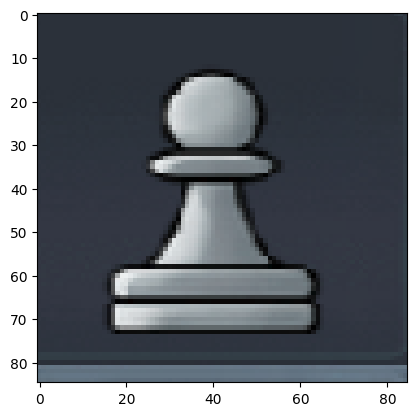

In [15]:
model_pred(model=tinyvgg, dataset=dataset)

# Train the model

In [16]:
def train_model(model, dataloader, loss_fn, optimizer, epochs):
    model.train()
    
    for epoch in range(epochs):
        for batch, (images, labels) in tqdm(enumerate(dataloader)):
            logits = model(images)
            loss = loss_fn(logits, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if batch % 10 == 0:
                print(f"loss for batch {batch} is {loss}")
                
    print(f"loss for the very last batch {loss}")

In [17]:
train_model(model=tinyvgg, dataloader=dataloader, loss_fn=loss_fn, optimizer=optimizer, epochs=10)

3it [00:00,  7.61it/s]

loss for batch 0 is 1.800648808479309


12it [00:01,  9.65it/s]

loss for batch 10 is 1.5276334285736084


17it [00:01,  9.56it/s]
1it [00:00,  9.76it/s]

loss for batch 0 is 1.6759768724441528


12it [00:01,  9.65it/s]

loss for batch 10 is 1.5164918899536133


17it [00:01, 10.21it/s]
2it [00:00,  9.01it/s]

loss for batch 0 is 1.5044656991958618


12it [00:01,  9.11it/s]

loss for batch 10 is 1.7182918787002563


17it [00:01,  9.51it/s]
2it [00:00,  9.31it/s]

loss for batch 0 is 1.5122779607772827


12it [00:01,  8.81it/s]

loss for batch 10 is 1.716396689414978


17it [00:01,  9.63it/s]
2it [00:00,  8.59it/s]

loss for batch 0 is 1.4646564722061157


12it [00:01,  7.59it/s]

loss for batch 10 is 1.3843867778778076


17it [00:02,  8.27it/s]
2it [00:00,  6.74it/s]

loss for batch 0 is 1.3900099992752075


11it [00:01,  7.76it/s]

loss for batch 10 is 1.4063787460327148


17it [00:02,  7.88it/s]
2it [00:00,  9.40it/s]

loss for batch 0 is 1.298710823059082


11it [00:01,  9.14it/s]

loss for batch 10 is 0.9598133563995361


17it [00:01,  9.54it/s]
2it [00:00,  9.23it/s]

loss for batch 0 is 0.32289832830429077


12it [00:01,  8.95it/s]

loss for batch 10 is 0.21249555051326752


17it [00:01,  9.73it/s]
2it [00:00,  9.50it/s]

loss for batch 0 is 0.08041656017303467


12it [00:01,  8.56it/s]

loss for batch 10 is 0.019555971026420593


17it [00:01,  9.54it/s]
2it [00:00,  9.73it/s]

loss for batch 0 is 0.09597928822040558


12it [00:01,  9.26it/s]

loss for batch 10 is 0.06406313925981522


17it [00:01, 10.06it/s]

loss for the very last batch 0.012747193686664104


# Test the model

model predicted --> bishop
label is 0 (bishop)


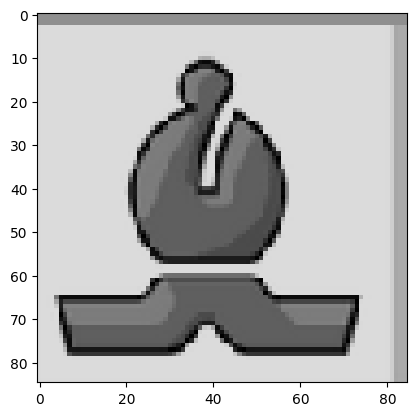

In [18]:
model_pred(model=tinyvgg, dataset=dataset)